In [1]:
import ctypes
import numpy as np
import copy
from scipy.signal import convolve2d

#so_file = "/home/benni/Coding/5.PK/Code/utils.so"
'''
utils = np.ctypeslib.load_library('utils', '.')

def convolve_sharedlib(inputMatrix, kernel, stride):
    a = np.array(inputMatrix, dtype="float64")
    b = np.array(kernel, dtype="float64")

    INT = ctypes.c_int64
    PINT = ctypes.POINTER(ctypes.c_int64)
    PDOUBLE = ctypes.POINTER(ctypes.c_double)
    ND_POINTER_4 = np.ctypeslib.ndpointer(dtype=np.float64, ndim=4, flags="C_CONTIGUOUS")

    utils.convolve.argtypes = [ND_POINTER_4, INT, INT, INT, INT, ND_POINTER_4, INT, INT, INT, INT, INT, PINT, PINT, PINT, PINT, PINT]
    utils.convolve.restype = PDOUBLE

    d1_out, d2_out, d3_out, d4_out, d5_out = INT(), INT(), INT(), INT(), INT()
    p_d1_out = ctypes.pointer(d1_out)
    p_d2_out = ctypes.pointer(d2_out)
    p_d3_out = ctypes.pointer(d3_out)
    p_d4_out = ctypes.pointer(d4_out)
    p_d5_out = ctypes.pointer(d5_out)
    out = utils.convolve(a, a.shape[0], a.shape[1], a.shape[2], a.shape[3], b, b.shape[0], b.shape[1], b.shape[2], b.shape[3], 1, p_d1_out, p_d2_out, p_d3_out, p_d4_out, p_d5_out)

    d1_out = d1_out.value
    d2_out = d2_out.value
    d3_out = d3_out.value
    d4_out = d4_out.value
    d5_out = d5_out.value
    result = np.ctypeslib.as_array(out, shape=(d1_out, d2_out, d3_out, d4_out, d5_out))
    return result
    '''

def getinputStackedColumns(inputMatrix, kernel_map_shape, stride):
    s0, s1, s2, s3 = inputMatrix.strides

    d1_input, d2_input, h_input, w_input = inputMatrix.shape
    h_kernel, w_kernel = kernel_map_shape

    out_shape = ( d1_input, d2_input, (h_input-h_kernel+1)//stride, (w_input-w_kernel+1)//stride, h_kernel, w_kernel)
    inputStackedColumns = np.lib.stride_tricks.as_strided(inputMatrix,
                                                          shape=out_shape,
                                                          strides=(s0, s1, stride*s2,stride*s3,s2, s3))
    return inputStackedColumns

def sigmoid(x):
    return (1 / (1 + np.exp(-x)) )

def softmax(x):
    return np.exp(x) / sum(np.exp(x))

def getPadding(h_kernel, w_kernel, h_input, w_input, stride):
    initial_h = h_input
    initial_w = w_input 
    
    while True:
        if (h_input-h_kernel+1)%stride!=0:
            h_input+=1
        else:
            break
            
    while True:
        w_input+=1
        if (w_input-w_kernel+1)%stride!=0:
            w_input+=1
        else:
            break

            
    return h_input-initial_h, w_input-initial_w

def Convolution_strided_img2col(inputMatrix, kernel_map, stride):
  
    d1_input, d2_input, h_input, w_input = inputMatrix.shape
    d_kernel, h_kernel, w_kernel = kernel_map.shape
    
    inputStackedColumns = getinputStackedColumns(inputMatrix, kernel_map.shape[1:], stride)
    
    out_shape = ( d1_input, d2_input, (h_input-h_kernel+1)//stride, (w_input-w_kernel+1)//stride, h_kernel, w_kernel)

    inputStackedColumns = inputStackedColumns.flatten()
    inputStackedColumns = np.reshape(inputStackedColumns, (d1_input, d2_input, (h_input-h_kernel+1)//stride * ((w_input-w_kernel+1)//stride), h_kernel*w_kernel ))
    kernel_map_edited = kernel_map.reshape(d_kernel, h_kernel*w_kernel).transpose()
    im2col_conv = np.einsum("ijkl,lm->jkm", inputStackedColumns, kernel_map_edited)
    im2col_conv = im2col_conv.swapaxes(0,2).swapaxes(1,2)
    im2col_conv = im2col_conv.reshape(im2col_conv.shape[0], im2col_conv.shape[1], out_shape[2], out_shape[3])
    return im2col_conv

def convolution(inputMatrix, kernel_map, stride):
    #d1_input, d2_input, h_input, w_input = inputMatrix.shape
    #d_kernel, h_kernel, w_kernel = kernel_map.shape

    #padding = getPadding(h_kernel, w_kernel, h_input, w_input, stride)
    #inputMatrix = np.pad(inputMatrix, ((0,0),(0,0),(0,padding[0]),(0,padding[1])))
    
    return Convolution_strided_img2col(inputMatrix, kernel_map, stride)


def Maxpooling(inputMatrix, kernel_shape, stride):

    d_kernel_map, d_input, h_input, w_input = inputMatrix.shape
    h_kernel, w_kernel = kernel_shape
    
    zeromargin_height = (h_input-h_kernel+1)%stride
    zeromargin_width = (w_input-w_kernel+1)%stride
    inputMatrix = np.pad(inputMatrix, ((0,0),(0,0),(0,zeromargin_height),(0,zeromargin_width)))
    
    windows = getinputStackedColumns(inputMatrix, kernel_shape, stride)
    
    out_shape = ( d_kernel_map, d_input, (h_input-h_kernel+1)//stride, (w_input-w_kernel+1)//stride, h_kernel, w_kernel)

    maxs = np.max(windows, axis=(4,5))
    maxs = maxs.reshape(d_kernel_map, d_input, (h_input-h_kernel+1)//stride, (w_input-w_kernel+1)//stride)
    return maxs

def Averagepooling(inputMatrix, kernel_shape, stride):
        
    d_kernel_map, d_input, h_input, w_input = inputMatrix.shape
    h_kernel, w_kernel = kernel_shape
    
    zeromargin_height = (h_input-h_kernel+1)%stride
    zeromargin_width = (w_input-w_kernel+1)%stride
    inputMatrix = np.pad(inputMatrix, ((0,0),(0,0),(0,zeromargin_height),(0,zeromargin_width)))
    
    windows = getinputStackedColumns(inputMatrix, kernel_shape, stride)
    
    out_shape = ( d_kernel_map, d_input, (h_input-h_kernel+1)//stride, (w_input-w_kernel+1)//stride, h_kernel, w_kernel)

    means = np.means(windows, axis=(4,5))
    means = means.reshape(d_kernel_map, d_input, (h_input-h_kernel+1)//stride, (w_input-w_kernel+1)//stride)
    return means

def RELU_Matrixoperation(inputMatrix):
    return np.maximum(inputMatrix, 0)

'''
def getPartialDerivativeConvolutionWRTkernelmap(inputMatrix, kernel_map, stride):
    #kernelmap is a 4d array

    inputStackedColumns = getinputStackedColumns(inputMatrix, kernel_map.shape[2:], stride)
    d1_input, d2_input, h_input, w_input = inputMatrix.shape
    d1_kernel, d2_kernel,h_kernel, w_kernel = kernel_map.shape

    inputStackedColumns = inputStackedColumns.flatten()
    inputStackedColumns = np.reshape(inputStackedColumns, (d1_input, d2_input, (h_input-h_kernel+1)//stride * ((w_input-w_kernel+1)//stride), h_kernel*w_kernel ))
    kernel_map_edited = kernel_map.reshape(d1_kernel, d2_kernel, h_kernel*w_kernel)
    im2col_conv = np.einsum("ijkl,ijl->ijk", inputStackedColumns, kernel_map_edited).reshape(d1_input,d2_input,(h_input-h_kernel+1)//stride,(w_input-w_kernel+1)//stride)
    return im2col_conv

def getPartialDerivativeConvolutionWRTx(kernel_map, gradient, stride):
   
    d_kernel_map, h_kernel_map, w_kernel_map = kernel_map.shape
    #5, 5, 5
    d1_gradient, d2_gradient, w_gradient, h_gradient = gradient.shape
    #5, 27, 170, 170
    
    result = []
    for i in range(d_kernel_map):
        onelayer = []
        
        for j in range(d2_gradient):
            
            img_result = convolve2d(kernel_map[i], gradient[i][j], mode="full")
            img_result = np.flip(img_result, axis=1)
            img_result = np.flip(img_result, axis=0)
            
            onelayer.append(img_result)
            
        result.append(onelayer)
    return np.array(result)
            

def getPartialDerivateMaxPool(inputMatrix, gradientPreviousLayer, kernel_shape, stride):
    windows = getinputStackedColumns(inputMatrix, kernel_shape, stride)

    max = np.max(windows, axis=(4,5)).flatten().repeat(4, axis=0).reshape(windows.shape)
    gradientPreviousLayer = gradientPreviousLayer.flatten().repeat(4, axis=0).reshape(windows.shape)
    mask = np.equal(max, windows)
    windows.fill(0)
    windows[mask]=gradientPreviousLayer[mask]
    windows = np.lib.stride_tricks.as_strided(windows,
                                              shape=inputMatrix.shape,
                                              strides=inputMatrix.strides)
    return windows

def getMask(inputMatrix):
    inputMatrix[inputMatrix<=0] = 0
    inputMatrix[inputMatrix!=0] = 1
    return inputMatrix
'''


'\ndef getPartialDerivativeConvolutionWRTkernelmap(inputMatrix, kernel_map, stride):\n    #kernelmap is a 4d array\n\n    inputStackedColumns = getinputStackedColumns(inputMatrix, kernel_map.shape[2:], stride)\n    d1_input, d2_input, h_input, w_input = inputMatrix.shape\n    d1_kernel, d2_kernel,h_kernel, w_kernel = kernel_map.shape\n\n    inputStackedColumns = inputStackedColumns.flatten()\n    inputStackedColumns = np.reshape(inputStackedColumns, (d1_input, d2_input, (h_input-h_kernel+1)//stride * ((w_input-w_kernel+1)//stride), h_kernel*w_kernel ))\n    kernel_map_edited = kernel_map.reshape(d1_kernel, d2_kernel, h_kernel*w_kernel)\n    im2col_conv = np.einsum("ijkl,ijl->ijk", inputStackedColumns, kernel_map_edited).reshape(d1_input,d2_input,(h_input-h_kernel+1)//stride,(w_input-w_kernel+1)//stride)\n    return im2col_conv\n\ndef getPartialDerivativeConvolutionWRTx(kernel_map, gradient, stride):\n   \n    d_kernel_map, h_kernel_map, w_kernel_map = kernel_map.shape\n    #5, 5, 5\n  

In [2]:
import numpy as np
import random as rd
from matplotlib import pyplot as plt
from matplotlib import image
import cv2
import csv
import os
import copy
#from matrixoperations import *

class Model:
    
    imgShape = None
    convout1 = None 
    pooling1 = None
    relu1 = None
    convout2 = None 
    pooling2 = None
    relu2 = None
    x = None
    a2 = None
    a3 = None    
    z2 = None
    z3 = None
    
    w1 = None
    w2 = None 
    kernelmap1 = None
    kernelmap2 = None
    pooling1kernelshape = None
    pooling2kernelshape = None
    
    measurementData_Loss = []
    measurementData_Accuracy = []
    
    def __init__(self, inputArrayShape, hyperparameters):
        np.random.seed(20)
        
        self.n_a2 = hyperparameters[0]
        self.n_a3 = hyperparameters[1]
        self.d_kernel1 = hyperparameters[2] 
        self.d_kernel2 = hyperparameters[3] 
        self.w_h_kernel1 = hyperparameters[4] 
        self.w_h_kernel2 = hyperparameters[5]
        self.pooling_method = hyperparameters[6] 
        self.w_h_pooling1 = hyperparameters[7] 
        self.w_h_pooling2 = hyperparameters[8] 
        self.strides_conv1 = hyperparameters[9] #
        self.strides_conv2 = hyperparameters[10] #
        self.strides_pooling1 = hyperparameters[11] #
        self.strides_pooling2 = hyperparameters[12] #
        self.learningrate = hyperparameters[13]
        self.batchsize = hyperparameters[14]
        
        self.pooling1kernelshape = (self.w_h_pooling1,self.w_h_pooling1)
        self.pooling2kernelshape = (self.w_h_pooling2,self.w_h_pooling2)
        
        self.kernelmap1 = np.random.uniform(-1,1,(self.d_kernel1,self.w_h_kernel1,self.w_h_kernel1))
        self.kernelmap2 = np.random.uniform(-1,1,(self.d_kernel2,self.w_h_kernel2,self.w_h_kernel2))
        
        self.imgShape = copy.copy(inputArrayShape)
        
        inputArrayShape.insert(0, 1)
        inputArrayShape.insert(0, 1) #input matrix: !one! example with depth !one!
        self.n_x = self.getNumberOutputNeuronsConvolutionalLayer(inputArrayShape)
        
        self.w1 = np.random.uniform(-1,1,(self.n_a2, self.n_x + 1))
        self.w2 = np.random.uniform(-1,1,(self.n_a3, self.n_a2 + 1))
         
    def getNumberOutputNeuronsConvolutionalLayer(self, inputArrayShape):

        self.input = np.zeros((inputArrayShape[0], inputArrayShape[1], inputArrayShape[2], inputArrayShape[3]))
        self.convout1 = convolution(self.input, self.kernelmap1, self.strides_conv1) 
        self.reluout1 = RELU_Matrixoperation(self.convout1)
        if self.pooling_method == "average":
            self.poolingout1 = Averagepooling(self.reluout1, self.pooling1kernelshape, self.strides_pooling1)
        elif self.pooling_method == "max":
            self.poolingout1 = Maxpooling(self.reluout1, self.pooling1kernelshape, self.strides_pooling1)
        else:
            self.poolingout1 = Maxpooling(self.reluout1, self.pooling1kernelshape, self.strides_pooling1)
        
        self.convout2 = convolution(self.poolingout1, self.kernelmap2, self.strides_conv2) 
        self.reluout2 = RELU_Matrixoperation(self.convout2)
        if self.pooling_method == "average":
            self.poolingout2 = Averagepooling(self.reluout2, self.pooling2kernelshape, self.strides_pooling2)
        elif self.pooling_method == "max":
            self.poolingout2 = Maxpooling(self.reluout2, self.pooling2kernelshape, self.strides_pooling2)
        else:
            self.poolingout2 = Maxpooling(self.reluout2, self.pooling2kernelshape, self.strides_pooling2)
        
        input = self.poolingout2
        
        
        return(input.shape[0]*input.shape[2]*input.shape[3])
        
    def propagateForward(self, input):
        #training examples in -input- arranged in stacked columns
        #kernel_map is a 3d-array containing all 2d kernels
        
        #convolutional layer 
        self.input = input.reshape(input.shape[0], 1, input.shape[1], input.shape[2]).swapaxes(0,1)
        self.convout1 = convolution(self.input, self.kernelmap1, self.strides_conv1) 
        self.reluout1 = RELU_Matrixoperation(self.convout1)
        if self.pooling_method == "average":
            self.poolingout1 = Averagepooling(self.reluout1, self.pooling1kernelshape, self.strides_pooling1)
        elif self.pooling_method == "max":
            self.poolingout1 = Maxpooling(self.reluout1, self.pooling1kernelshape, self.strides_pooling1)
        else:
            self.poolingout1 = Maxpooling(self.reluout1, self.pooling1kernelshape, self.strides_pooling1)
        
        self.convout2 = convolution(self.poolingout1, self.kernelmap2, self.strides_conv2) 
        self.reluout2 = RELU_Matrixoperation(self.convout2)
        if self.pooling_method == "average":
            self.poolingout2 = Averagepooling(self.reluout2, self.pooling2kernelshape, self.strides_pooling2)
        elif self.pooling_method == "max":
            self.poolingout2 = Maxpooling(self.reluout2, self.pooling2kernelshape, self.strides_pooling2)
        else:
            self.poolingout2 = Maxpooling(self.reluout2, self.pooling2kernelshape, self.strides_pooling2)
                
        self.x = self.poolingout2.reshape(self.poolingout2.shape[0], self.poolingout2.shape[1], self.poolingout2.shape[2]*self.poolingout2.shape[3])
        self.x = np.concatenate(self.x, axis=1).transpose()
        self.x = np.pad(self.x, ((1,0),(0,0)), constant_values=1)
        
        #dense layer
        self.z2 = np.dot(self.w1, self.x)
        self.a2 = sigmoid(self.z2)
        self.a2 = np.pad(self.a2, ((1,0),(0,0)), constant_values=1)
        
        self.z3 = np.dot(self.w2, self.a2)
        self.a3 = softmax(self.z3)
        
        return self.a3
        
    def propagateBackward(self, input, y_hat, learningrate):
        self.propagateForward(input)
        pd_L_wrt_a3 = 1/input.shape[0] * (self.a3 - y_hat)
        pd_z3_wrt_w2 = self.a2
        pd_L_wrt_w2 = np.dot(pd_L_wrt_a3, pd_z3_wrt_w2.T)
        
        pd_z3_wrt_a2 = self.w2
        pd_a2_wrt_z2 = sigmoid(self.z2)*(1 - sigmoid(self.z2))
        pd_z2_wrt_w1 = self.x
        pd_L_wrt_w1 = np.dot( np.dot(pd_L_wrt_a3.T, pd_z3_wrt_a2[:,1:]).T * pd_a2_wrt_z2, pd_z2_wrt_w1.T)
        
        
        '''
        pd_z2_wrt_x = self.w1
        pd_L_wrt_x = np.dot( (np.dot((pd_L_wrt_a3).T, pd_z3_wrt_a2[:,1:]).T * pd_a2_wrt_z2).T, pd_z2_wrt_x[:,1:]).T
        pd_L_wrt_x = np.reshape(pd_L_wrt_x, self.poolingout2.shape)
        
        pd_L_wrt_pooling2 = getPartialDerivateMaxPool(self.reluout2, pd_L_wrt_x, (2,2), 1)
        mask = getMask(self.convout2)
        pd_L_wrt_RELU2 = pd_L_wrt_pooling2*mask
        pd_L_wrt_kernelmap2 = getPartialDerivativeConvolutionWRTkernelmap(self.poolingout1, pd_L_wrt_RELU2, 1).sum(axis=1)
        pd_L_wrtRELUout1 = getPartialDerivativeConvolutionWRTx(self.kernelmap2, pd_L_wrt_RELU2, 1)
        
        pd_L_wrt_pooling1 = getPartialDerivateMaxPool(self.reluout1, pd_L_wrtRELUout1, (2,2), 1)
        mask = getMask(self.convout1)
        pd_L_wrt_RELU1 = pd_L_wrt_pooling1*mask
        
        pd_L_wrt_kernelmap1 = getPartialDerivativeConvolutionWRTkernelmap(self.input, pd_L_wrt_RELU1, 1)
        '''
        
        self.w2 = self.w2 - self.learningrate * pd_L_wrt_w2
        self.w1 = self.w1 - self.learningrate * pd_L_wrt_w1
        #self.kernelmap2 = self.kernelmap2 - stepsize * pd_L_wrt_kernelmap2
        
    def getDataBatch(self, path, filenames):
        uniform_size = self.imgShape[::-1]
        
        data_x = []
        data_y = []
        
        for i in filenames:
            
            img = image.imread(path + "//" + i)
            if len(img.shape)==3:
                img = np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])
            resized_img = cv2.resize(img, dsize=uniform_size, interpolation=cv2.INTER_CUBIC)
            data_x.append(resized_img)


            y = None
            if "y" in i:
                y = np.array([1,0])
            else:
                y = np.array([0,1])
            data_y.append(y)
            
        data_x = np.array(data_x).astype(np.float)  
        data_y = np.array(data_y).astype(np.float).transpose()
        
        return(data_x, data_y)
        
    def train(self, epochs, trainpath, testpath):
        
        trainfilenames = os.listdir(trainpath)
        testfilenames = os.listdir(testpath)
        
        np.random.shuffle(trainfilenames)
        np.random.shuffle(testfilenames)
        
        batch_counter = 0
        for i in range(epochs):
            filenamesBatch = trainfilenames[batch_counter:batch_counter+self.batchsize]
            
            data = self.getDataBatch(trainpath, filenamesBatch)
            input = data[0]
            y_hat = data[1]
            self.propagateBackward(input, y_hat, self.learningrate)
            loss = 1/input.shape[0] * ((self.a3 - y_hat)**2).sum()
            
            data_test = self.getDataBatch(testpath, testfilenames[:100])
            accuracy = self.test(data_test[0], data_test[1])
            print("Epoch " + str(i) + " done. Loss: " + str(loss) + " Accuracy: " + str(accuracy*100) + " %")
            self.measurementData_Accuracy.append(accuracy)
            self.measurementData_Loss.append(loss)
            
            batch_counter += self.batchsize
            if (batch_counter>=2700-self.batchsize):
                batch_counter = 0
            
    def test(self, input, y_hat):
        fx = self.propagateForward(input)
        number_correct = 0
        number_overall = fx[:,:100].shape[1]
        for i in range(number_overall):
            arrayfx = fx[:,i:i+1]
            arrayy = y_hat[:,i:i+1]
           
            indexmaxfx = np.argmax(arrayfx, axis=0)
            indexmaxy = np.argmax(arrayy, axis=0)
            if (indexmaxfx[0]==indexmaxy[0]):
                number_correct += 1
                
        return number_correct/number_overall
    
    def getMeasurementData(self):
        return (self.measurementData_Loss, self.measurementData_Accuracy)

In [3]:
n_a2 = 50
n_a3 = 2
d_kernel1 = 5
d_kernel2 = 5
w_h_kernel1 = 5 
w_h_kernel2 = 5
pooling_method = "max"
w_h_pooling1 =  2
w_h_pooling2 = 2
strides_conv1 = 1 #
strides_conv2 = 1 #
strides_pooling1 = 1 #
strides_pooling2 = 1 #
learningrate = 0.01
batchsize = 27


m = Model([175, 167], (n_a2, n_a3, d_kernel1, d_kernel2, w_h_kernel1, w_h_kernel2, pooling_method, w_h_pooling1, w_h_pooling2, strides_conv1, strides_conv2, strides_pooling1, strides_pooling2, learningrate, batchsize))
m.train(500, "C://Users//Benni//Desktop//PK//Dateset//yes_and_no//train", "C://Users//Benni//Desktop//PK//Dateset//yes_and_no//test")

c:\users\benni\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:190: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\users\benni\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:191: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\users\benni\appdata\local\programs\python\python37\

Epoch 0 done. Loss: 0.6104988188169179 Accuracy: 60.0 %
Epoch 1 done. Loss: 0.6737454355052727 Accuracy: 60.0 %
Epoch 2 done. Loss: 0.6997626547628077 Accuracy: 62.0 %
Epoch 3 done. Loss: 0.5594354468118392 Accuracy: 62.0 %
Epoch 4 done. Loss: 0.6098262694523453 Accuracy: 63.0 %
Epoch 5 done. Loss: 0.4967645890968739 Accuracy: 63.0 %
Epoch 6 done. Loss: 0.5961928053096901 Accuracy: 63.0 %
Epoch 7 done. Loss: 0.4116353131355919 Accuracy: 63.0 %
Epoch 8 done. Loss: 0.4451542758297805 Accuracy: 63.0 %
Epoch 9 done. Loss: 0.5545790169578624 Accuracy: 63.0 %
Epoch 10 done. Loss: 0.3880053109634454 Accuracy: 62.0 %
Epoch 11 done. Loss: 0.6262199740861057 Accuracy: 63.0 %
Epoch 12 done. Loss: 0.4767893354442097 Accuracy: 63.0 %
Epoch 13 done. Loss: 0.5607311947298355 Accuracy: 63.0 %
Epoch 14 done. Loss: 0.7218244397484597 Accuracy: 64.0 %
Epoch 15 done. Loss: 0.565706519566704 Accuracy: 64.0 %
Epoch 16 done. Loss: 0.5055247586176346 Accuracy: 64.0 %
Epoch 17 done. Loss: 0.712088359137137 Acc

KeyboardInterrupt: 

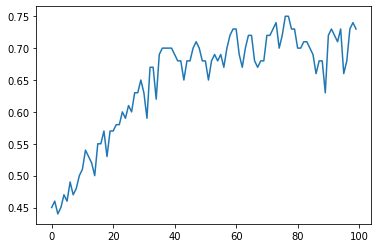

In [168]:
plt.plot(m.measurementData_Accuracy)

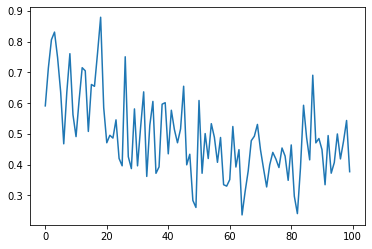

In [169]:
plt.plot(m.measurementData_Loss)

In [179]:
n_a2 = 50
n_a3 = 2
d_kernel1 = 5
d_kernel2 = 5
w_h_kernel1 = 5 
w_h_kernel2 = 5
pooling_method = "max"
w_h_pooling1 =  2
w_h_pooling2 = 2
strides_conv1 = 1 
strides_conv2 = 1 
strides_pooling1 = 1 #
strides_pooling2 = 1 #
learningrate = 0.1
batchsize = 27


n = Model([175, 167], (n_a2, n_a3, d_kernel1, d_kernel2, w_h_kernel1, w_h_kernel2, pooling_method, w_h_pooling1, w_h_pooling2, strides_conv1, strides_conv2, strides_pooling1, strides_pooling2, learningrate, batchsize))
n.train(125, "C://Users//Benni//Desktop//PK//Dateset//yes_and_no//train", "C://Users//Benni//Desktop//PK//Dateset//yes_and_no//test")

c:\users\benni\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:190: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\users\benni\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:191: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\users\benni\appdata\local\programs\python\python37\

Epoch 0 done. Loss: 0.6104988188169179 Accuracy: 64.0 %
Epoch 1 done. Loss: 0.6442643166345643 Accuracy: 65.0 %
Epoch 2 done. Loss: 0.6212704226431827 Accuracy: 64.0 %
Epoch 3 done. Loss: 0.6152745368382256 Accuracy: 67.0 %


KeyboardInterrupt: 

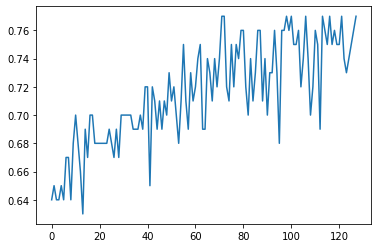

In [177]:
plt.plot(n.measurementData_Accuracy)

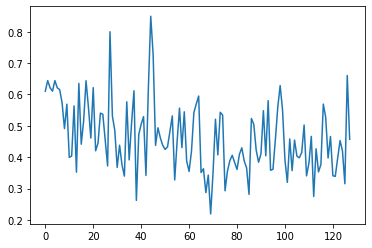

In [178]:
plt.plot(n.measurementData_Loss)

In [ ]:
print(m.test(data_x_test, data_y_test))


c:\users\benni\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':


[[0.09141944]
 [0.90858056]]


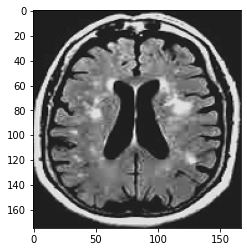

In [38]:
result = m.propagateForward(data_x_test[1:2,:])
print(result)
plt.imshow(data_x_test[1], cmap=plt.get_cmap('gray'))

In [13]:
x = np.array([[1,2],[2,3]])
y = np.array([[2,3],[4,5]])
x*y

array([[ 2,  6],
       [ 8, 15]])

In [76]:
((175-7)%5)-1

2